In [53]:
import pyvisa
import struct
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

import sys
import os

sys.path.insert(1, os.path.join(sys.path[0], '..')) # Hack (:
from src import icsp as icsp
from src.icsp import devices

PORT = '/dev/ttyACM0'
BAUDRATE = 115200
TIMEOUT = 0.1
MEM_OP_TIMEOUT = 5
SCOPE_IP_ADDRESS = "192.168.0.111"

pic = icsp.ICSP(devices.PIC16LF1936 , PORT, BAUDRATE, TIMEOUT, MEM_OP_TIMEOUT)

In [33]:
# def test_connection():
#     s.write(b"P")
#     print(s.read(4))

In [34]:
pic.ping()

(True, b'p')

In [35]:
rm = pyvisa.ResourceManager()

In [36]:
instrument = rm.open_resource('TCPIP::' + SCOPE_IP_ADDRESS + '::INSTR')

In [37]:
instrument.write('ACQUIRE:TYPE NORMAL')  # Set acquisition type to normal mode

21

In [38]:
instrument.query('*IDN?')

'Siglent Technologies,SDS1204X-E,SDSMMFCD5R0232,8.1.6.1.37R6\n'

In [39]:
instrument.write('ARM')

5

In [40]:
instrument.query('sara?')

'SARA 5.00E+08Sa/s\n'

In [41]:
def acquire_trace():
    instrument.write('ARM')
    time.sleep(0.5)
    # pic.read_program(0, 1)
    pic.s.write(b"A") # Atomic read command
    time.sleep(0.5)
    instrument.write('c4:wf? dat2') # Get channel 4's WaveForm main data (dat2) with start and end markers
    ints = []
    for qq in instrument.read_raw()[22:-2]:
        if qq > 127:
            qq = qq - 255
        else:
            pass
        ints.append(qq)
    return ints

In [42]:
# # First few empty runs
# acquire_trace()
# acquire_trace()
# acquire_trace()
# # Now the real thing

# with open('traces_cp_disabled.bin', 'wb') as f:
#     i = 0
#     while i < 1000:
#         if i % 20 == 0:
#             print(i, end=' ', flush=True)
#         if i % 500 == 0:
#             print()
#         try:
#             arr = np.asarray(acquire_trace(), dtype=np.int8)
#             np.save(f, arr, allow_pickle=False)
#             i += 1
#         except Exception as e:
#             print()
#             print(e)
#             print("Retrying...")

In [43]:
# First few empty runs
acquire_trace()
acquire_trace()
acquire_trace()
# Now the real thing
traces_cp_disabled = []
i = 0
while i < 100:
    if i % 20 == 0:
        print(i, end=' ', flush=True)
    if i % 500 == 0 and i != 0:
        print()
    try:
        traces_cp_disabled.append(acquire_trace())
        i += 1
    except Exception as e:
        print()
        print(e)
        print("Retrying...")

0 20 40 60 80 

In [54]:
with open('traces_cp_disabled.pickle', 'wb') as f:
    pickle.dump(traces_cp_disabled, f)

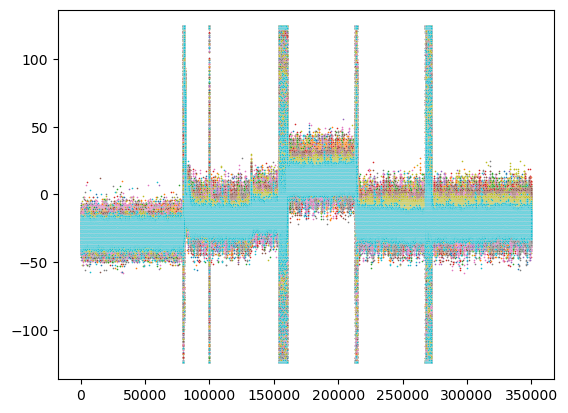

In [44]:
for trace in traces_cp_disabled:
    sns.scatterplot(trace, s=1.5)
plt.show()

In [45]:
pic.write_program(0x8007, struct.pack('<h', 0x3F7F))

In [46]:
# First few empty runs
acquire_trace()
acquire_trace()
acquire_trace()
# Now the real thing
traces_cp_enabled = []
i = 0
while i < 100:
    if i % 20 == 0:
        print(i, end=' ', flush=True)
    if i % 500 == 0 and i != 0:
        print()
    try:
        traces_cp_enabled.append(acquire_trace())
        i += 1
    except Exception as e:
        print()
        print(e)
        print("Retrying...")

0 20 40 60 80 

In [55]:
with open('traces_cp_enabled.pickle', 'wb') as f:
    pickle.dump(traces_cp_enabled, f)

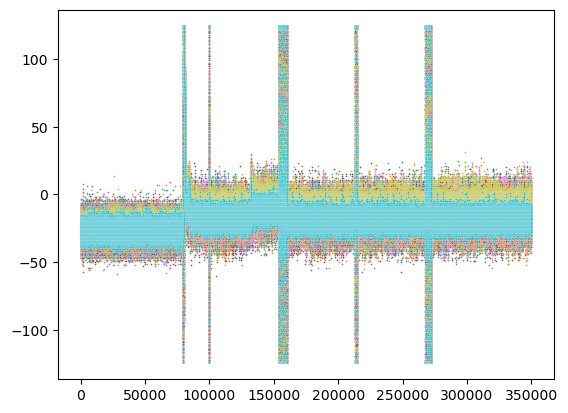

In [47]:
for trace in traces_cp_enabled:
    sns.scatterplot(trace, s=1.5)
plt.show()

In [48]:
pic.s.close()

In [49]:
hamming_weight = lambda x: bin(x).count("1")
PP = np.concatenate((
		np.full(len(traces_cp_enabled), hamming_weight(0x3F7F)),
		np.full(len(traces_cp_disabled), hamming_weight(0x3FFF)),
))

In [50]:
MM = np.array(traces_cp_enabled + traces_cp_disabled)

p_corrs = []

for column in MM.T:
	p_corrs.append(np.corrcoef(column, PP)[0][1])

/usr/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

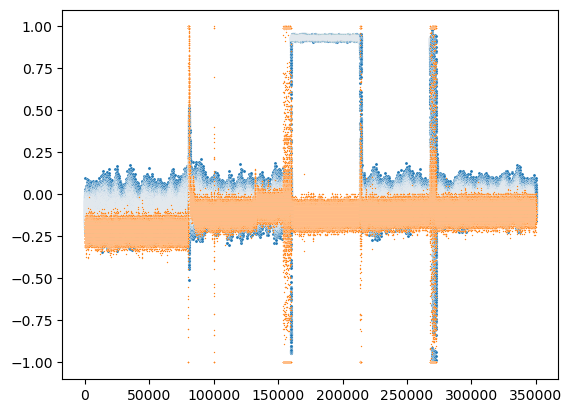

In [51]:
sns.scatterplot(p_corrs, s = 5)

trace = traces_cp_enabled[0]
trace /= np.max(np.abs(trace), axis=0) # Normalize to -1..1
sns.scatterplot(trace, s = 1)